### Laboratorium 4 - zadania

In [2]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic

#### Zadanie 1

Dane są obrazy `tabby` i `pills`. Wykonaj dla nich segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie **jednolitych**  superpikseli, a więc zawierających tylko fragmenty obiektów lub tylko tła (a nie jednego i drugiego naraz). Przeanalizuj zachowanie algorytmu dla różnej liczby superpikseli i parametru sigma.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC - [`skimage.segmentation.slic`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic) - (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja [`mark_boundaries`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries).

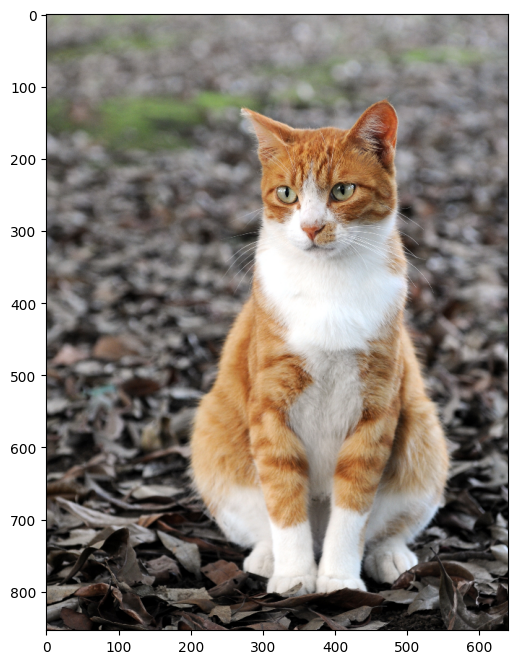

In [3]:
_ = cv2.imread('tabby.jpg')[..., ::-1]
tabby = cv2.resize(_, dsize=None, fx=0.3, fy=0.3)
plt.subplots(1,1,figsize=(8,8))[1].imshow(tabby);

- n_segments - liczba segmentów
- sigma - rozmiar kernela dla Gaussian smoothing
- compactness - "kwadratowość" segmentów

In [48]:
n_segments = [50, 100, 150, 200]
sigma = [1,3,5,7]

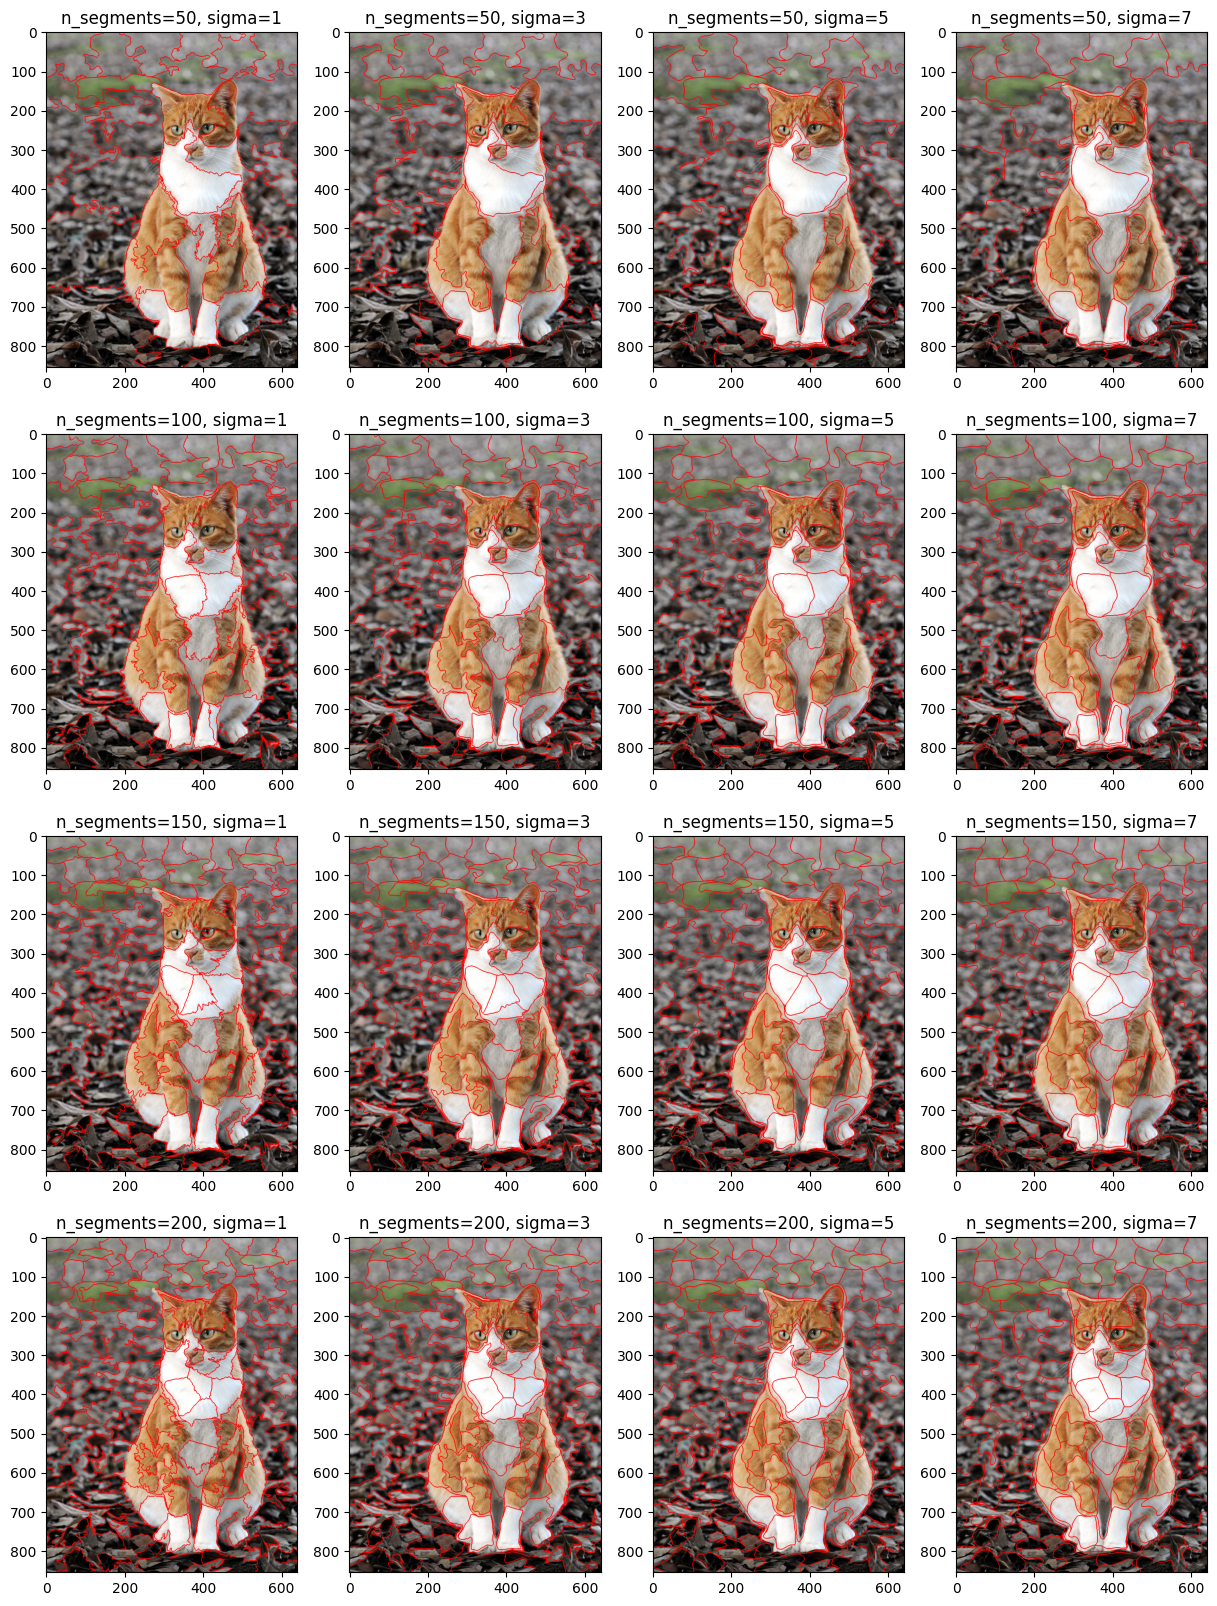

In [50]:
plt.figure(figsize=(15,20))
for i, n in enumerate(n_segments):
    for j, s in enumerate(sigma):
        segments = slic(tabby, n_segments=n, sigma=s)
        plt.subplot(4,4,1+i*4+j)
        segmnet_image = mark_boundaries(tabby, segments, color=(1,0,0))
        plt.imshow(segmnet_image)
        plt.title(f'n_segments={n}, sigma={s}')
plt.show()

Text(0.5, 1.0, 'n_segments=200, sigma=7')

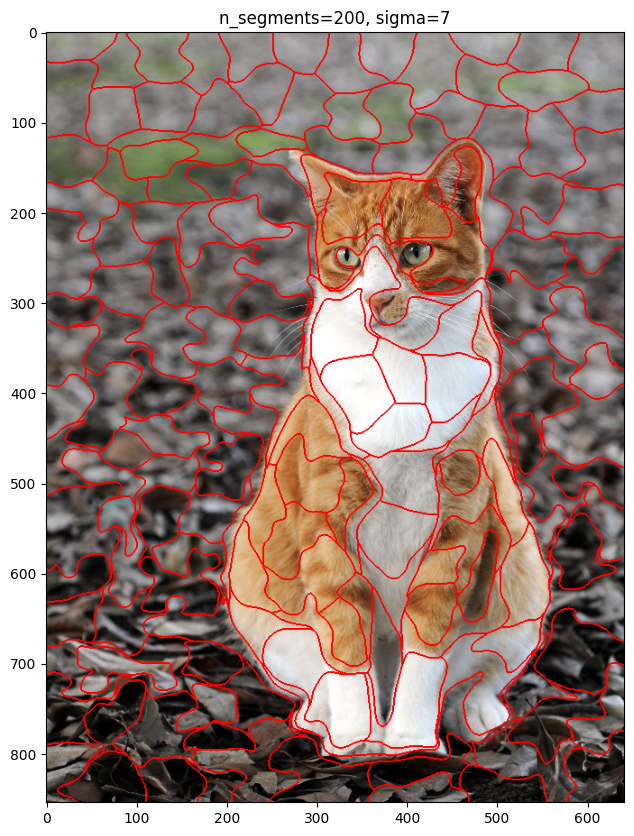

In [55]:
plt.figure(figsize=(15,10))
segments_tabby = slic(tabby, n_segments=200, sigma=7)
segmnet_tabby_image = mark_boundaries(tabby, segments, color=(1,0,0))
plt.imshow(segmnet_image)
plt.title(f'n_segments={n}, sigma={s}')

Sigma wpływa na 'miękkość' granic - czym większa sigma tym granice są bardziej zaokrąglone i łagodniejsze. Dodatkowo krawędzie obrazu są lepiej wykrywane, przez co superpiksele lepiej dopasowywują się do obrazu

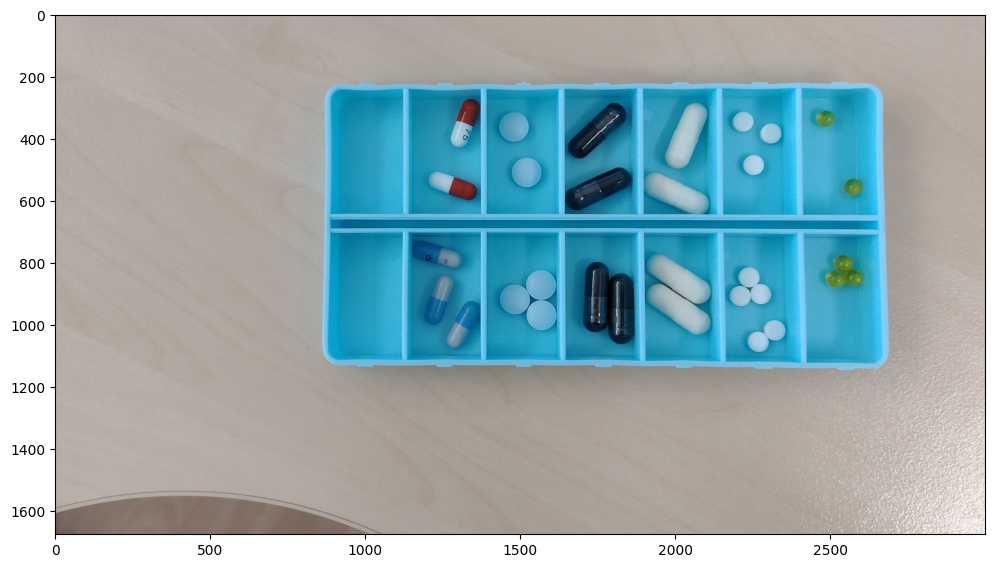

In [40]:
pills = cv2.imread('pills.png')[..., ::-1]
plt.subplots(1,1,figsize=(12,8))[1].imshow(pills);

In [41]:
lab_pills = cv2.cvtColor(pills, cv2.COLOR_RGB2LAB)

In [38]:
n_segments = [700, 850, 1000, 1150]

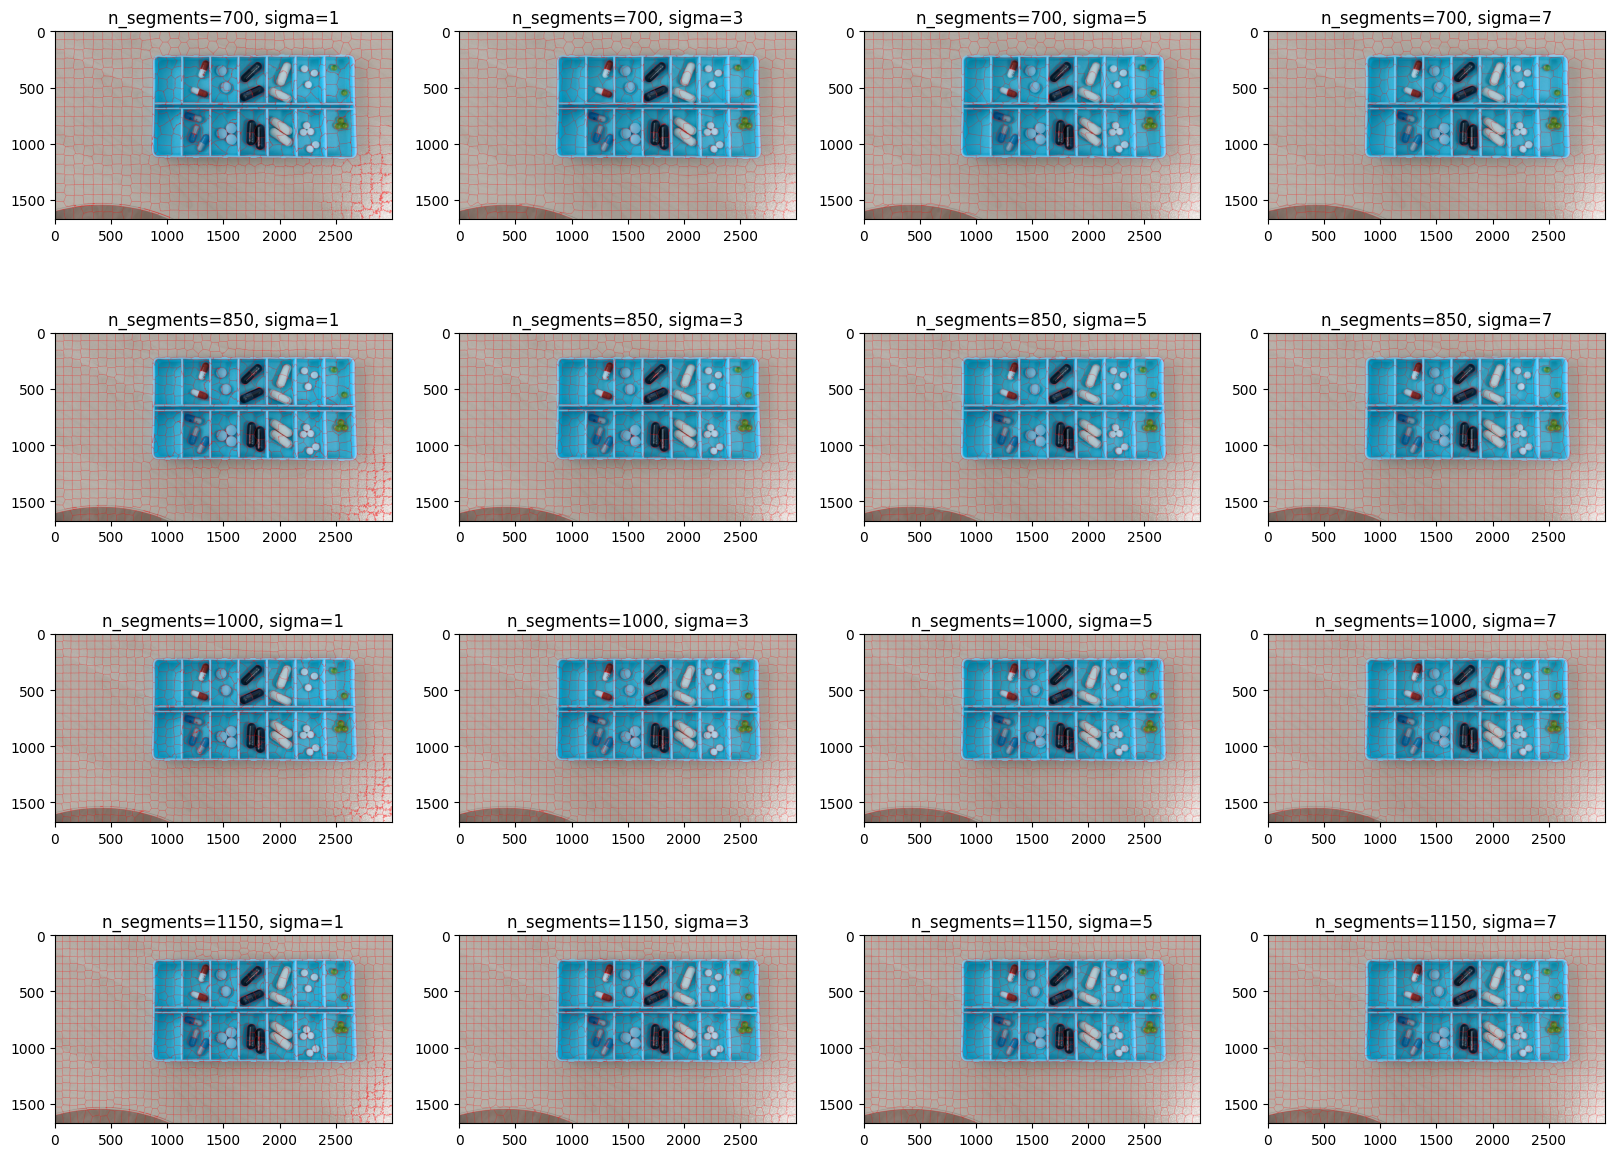

In [43]:
plt.figure(figsize=(20,15))
for i, n in enumerate(n_segments):
    for j, s in enumerate(sigma):
        segments = slic(lab_pills, n_segments=n, sigma=s)
        plt.subplot(4,4,1+i*4+j)
        segmnet_image = mark_boundaries(pills, segments, color=(1,0,0))
        plt.imshow(segmnet_image)
        plt.title(f'n_segments={n}, sigma={s}')
plt.show()

Text(0.5, 1.0, 'n_segments=1500, sigma=5')

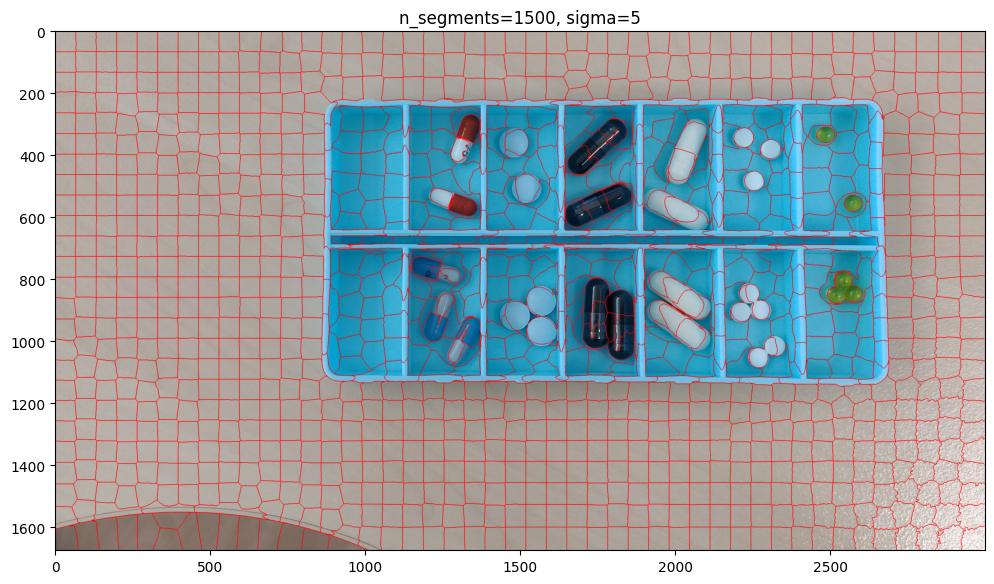

In [45]:
plt.figure(figsize=(12,8))
segments = slic(lab_pills, n_segments=1150, sigma=3)
segmnet_image = mark_boundaries(pills, segments, color=(1,0,0))
plt.imshow(segmnet_image)
plt.title(f'n_segments=1500, sigma=5')

#### Zadanie 2

Dla obrazu `tabby` wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie kota, drugi zawierający wyłącznie tło.

Można to zadanie potraktować jako binaryzację na poziomie superpikseli i zrealizować je za pomocą progowania. 
Można też potraktować je jako klasteryzację superpikseli i wykorzystać np. [`cv2.kmeans`](https://docs.opencv.org/4.x/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88).  
Niezależnie od wybranej ścieżki, konieczne będzie opisanie każdego z superpikseli za pomocą jakiejś *cechy* go opisującej (lub kilku cech). Najprostszymi cechami mogą być np. średnie wartości składowych barwy pikseli wchodzących w skład superpiksela.  
Do zastanowienia: jakie parametry SLICa wybrać jako podstawę w tym zadaniu?

Zaprezentuj wyniki albo za pomocą `mark_boundaries` albo wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać:  
```A[B==5] = 0```  
Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

---

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

In [ ]:
# zacznij od przygotowania macierzy wejściowej (data) reprezentującej superpiksele jako punkty danych

In [71]:
n_segments = len(np.unique(segments_tabby))

In [389]:
data = []
for i in range(1, n_segments+1):
    mask = (segments_tabby == i)
    color = cv2.mean(tabby, mask.astype(np.uint8))
    # color = color[1]/color[2]
    # color = np.max(tabby[mask], axis=0).astype(np.float32)
    data.append(color)

data = np.array(data, dtype=np.float32)
# data = (data - np.min(data)) / (np.max(data) - np.min(data))
data.shape

(174, 4)

In [390]:
criteria = (cv2.TERM_CRITERIA_EPS, 10, 1.0)
k = 2  # liczba klastrów
_, labels, _ = cv2.kmeans(data, k, None, criteria, 1, cv2.KMEANS_RANDOM_CENTERS)

In [391]:
binary_image = np.zeros(segments_tabby.shape, dtype=np.uint8)

for i in range(n_segments):
    binary_image[segments_tabby == i] = 255 if labels[i] == 1 else 0

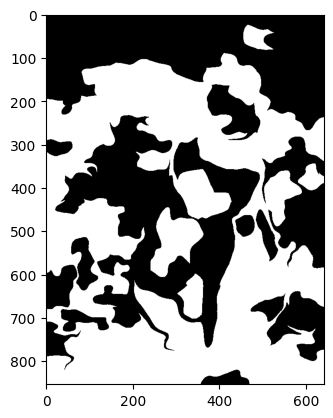

In [392]:
plt.imshow(binary_image, cmap='gray')